In [19]:
import gzip
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics, manifold
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [23]:
# http://yann.lecun.com/exdb/mnist/

with gzip.open('./data/train-images-idx3-ubyte.gz', 'rb') as f:
    train_x = np.frombuffer(f.read(), np.uint8, offset=16)
    train_x = train_x.reshape(60000, 28, 28)
    
with gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    valid_x = np.frombuffer(f.read(), np.uint8, offset=16)
    valid_x = valid_x.reshape(10000, 28, 28)

with gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_y = np.frombuffer(f.read(), np.uint8, offset=8)
    
with gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    valid_y = np.frombuffer(f.read(), np.uint8, offset=8)
    
train_sample_index = np.random.choice(60000, size=10000)
train_x_sample = train_x[train_sample_index, :, :]
train_y_sample = train_y[train_sample_index]
valid_sample_index = np.random.choice(10000, size=1000)
valid_x_sample = valid_x[valid_sample_index, :, :]
valid_y_sample = valid_y[valid_sample_index]

train_x_sample.shape, train_y_sample.shape, valid_x_sample.shape, valid_y_sample.shape

((10000, 28, 28), (10000,), (1000, 28, 28), (1000,))

In [24]:
class TransformDataset(chainer.dataset.DatasetMixin):
    
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def get_example(self, i):
        x, y = self.data[i][0], self.data[i][1]
        return x, y
    
def to_rgb(x):
    
    w, h = x.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = x
    ret[:, :, 1] = x
    ret[:, :, 2] = x
    
    return ret

In [25]:
train_dataset = TransformDataset([(to_rgb(x).transpose(2, 0, 1).astype(np.float32), np.int32(y)) for x, y in zip(train_x_sample, train_y_sample)])
valid_dataset = TransformDataset([(to_rgb(x).transpose(2, 0, 1).astype(np.float32), np.int32(y)) for x, y in zip(valid_x_sample, valid_y_sample)])
len(train_dataset), len(valid_dataset)

(10000, 1000)

In [26]:
class Model(chainer.Chain):
    
    def __init__(self):
        
        super(Model, self).__init__(
            conv1 = L.Convolution2D(3, 16, 3),
            conv2 = L.Convolution2D(16, 32, 3),
            fc3 = L.Linear(None, 100),
            fc4 = L.Linear(100, 10)
        )
    
    def __call__(self, x, layers=False):
        
        h1 = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h2 = F.max_pooling_2d(F.relu(self.conv2(h1)), 2)
        h3 = F.relu(self.fc3(h2))
        y = self.fc4(h3)
        
        if layers:
            return {'conv1': h1, 'conv2': h2, 'fc3': h3, 'fc4': y}
        
        return y

In [27]:
gpu = -1

model = L.Classifier(Model())
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

In [28]:
epoch_num = 12
batch_size = 1024

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu))
trainer.extend(extensions.LogReport(trigger=(3, 'epoch')))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
3           21.4448     6.86939               0.586035       0.726667                  63.0497       
6           1.06634     1.08616               0.882274       0.89                      109.985       
9           0.452381    0.713904              0.934739       0.914667                  163.106       
12          0.236628    0.610027              0.95651        0.926333                  213.138       


In [31]:
number = 0
target_valid_x = valid_x[np.where(valid_y == number)][:1]
gcams = np.zeros((len(target_valid_x), 28, 28), dtype=np.float32)

x_org = target_valid_x[0]

y = number
x = to_rgb(x_org).transpose(2,0,1).astype(np.float32)
x = x[np.newaxis]

with chainer.using_config('train', False):
    
    acts = model.predictor(x, layers=True)
    one_hot = model.xp.zeros((1, 10), dtype=np.float32)
    one_hot[:, y] = 1
    model.cleargrads()
    loss = F.sum(chainer.Variable(one_hot)*F.log_softmax(acts['fc4']))
    loss.backward(retain_grad=True)
    
cam = acts['conv2']

In [35]:
cam.grad.shape

(1, 32, 6, 6)

In [43]:
cam.grad[0][]

array([[[ 8.87628815e-09,  1.92355853e-11, -6.27636654e-09,
         -1.58279949e-08,  5.94580785e-09,  2.15358376e-09],
        [-8.29344859e-09,  7.64287389e-09,  2.32578508e-08,
          3.98481426e-09,  1.61999356e-08, -9.95430405e-09],
        [ 1.49381962e-09,  1.25965052e-08, -1.22560468e-08,
          9.56641255e-09,  5.59862734e-09,  1.47511514e-08],
        [ 5.82354076e-09, -3.25825500e-09,  1.59885918e-08,
          1.39567549e-08, -6.22618757e-09, -9.50363166e-09],
        [-1.21401067e-08, -2.09821902e-08,  1.99011634e-08,
         -1.22980790e-08, -6.51962395e-09,  5.56355273e-09],
        [-6.43120535e-09,  3.44722273e-09,  6.93162505e-09,
          3.58662960e-10, -7.56266871e-09, -7.62312347e-09]],

       [[ 1.28417064e-08,  1.27942745e-09,  9.90887017e-09,
         -4.56988447e-09, -2.54226915e-08, -2.17033040e-08],
        [ 1.17432384e-08, -8.33212965e-09,  9.27067312e-09,
         -1.52067414e-09, -1.16301624e-09, -8.46718162e-09],
        [ 3.99845002e-09,  1.2

In [45]:
F.relu(cam.grad)

variable([[[[8.87628815e-09, 1.92355853e-11, 0.00000000e+00,
             0.00000000e+00, 5.94580785e-09, 2.15358376e-09],
            [0.00000000e+00, 7.64287389e-09, 2.32578508e-08,
             3.98481426e-09, 1.61999356e-08, 0.00000000e+00],
            [1.49381962e-09, 1.25965052e-08, 0.00000000e+00,
             9.56641255e-09, 5.59862734e-09, 1.47511514e-08],
            [5.82354076e-09, 0.00000000e+00, 1.59885918e-08,
             1.39567549e-08, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 1.99011634e-08,
             0.00000000e+00, 0.00000000e+00, 5.56355273e-09],
            [0.00000000e+00, 3.44722273e-09, 6.93162505e-09,
             3.58662960e-10, 0.00000000e+00, 0.00000000e+00]],

           [[1.28417064e-08, 1.27942745e-09, 9.90887017e-09,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [1.17432384e-08, 0.00000000e+00, 9.27067312e-09,
             0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [3

In [36]:
w = model.xp.mean(cam.grad, axis=(2,3))

In [37]:
w.shape

(1, 32)

In [44]:
w

array([[ 1.0806889e-09, -4.0021989e-10,  2.2961075e-09, -1.9029860e-09,
        -4.6848614e-10, -2.9722780e-09,  2.1401487e-09,  6.9793538e-10,
        -3.2858087e-09, -1.4166815e-09,  4.5904280e-09, -6.2112032e-10,
         2.9990552e-09,  3.9491725e-09, -3.7332767e-10, -1.4076035e-09,
         2.0484587e-09, -5.5793620e-10, -2.7104644e-10,  1.5589403e-09,
        -5.8868427e-10, -4.4368800e-10, -5.2882498e-10, -2.0207751e-09,
         1.0003960e-09, -8.9974111e-10,  6.6589756e-10,  3.6430674e-09,
         5.3496318e-10,  1.8109658e-09,  1.1335545e-09, -3.7255345e-09]],
      dtype=float32)

In [46]:
gcam = model.xp.tensordot(w[0], cam.data[0], axes=(0, 0))

In [49]:
w[0].shape, cam.data[0].shape

((32,), (32, 6, 6))

In [47]:
gcam.shape

(6, 6)

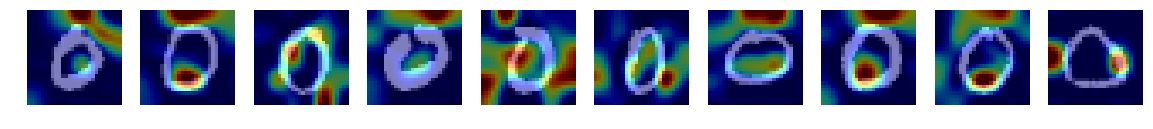

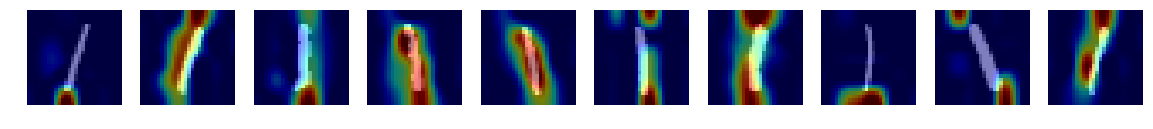

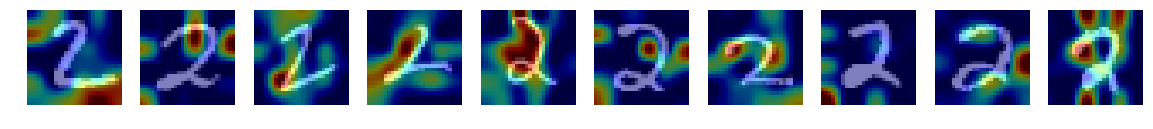

In [29]:
for number in range(3):

    fig, axs = plt.subplots(ncols=10, nrows=1, figsize=(20, 5))

    target_valid_x = valid_x[np.where(valid_y == number)]
    gcams = np.zeros((len(target_valid_x), 28, 28), dtype=np.float32)

    for i, x_org in enumerate(target_valid_x):

        y = number
        x = to_rgb(x_org).transpose(2, 0, 1).astype(np.float32)
        x = x[np.newaxis]

        with chainer.using_config('train', False):

            acts = model.predictor(x, layers=True)
            one_hot = model.xp.zeros((1, 10), dtype=np.float32)
            one_hot[:, y] = 1
            model.cleargrads()
            loss = F.sum(chainer.Variable(one_hot)*F.log_softmax(acts['fc4']))
            loss.backward(retain_grad=True)

        cam = acts['conv2']
        w = model.xp.mean(cam.grad, axis=(2, 3))
        gcam = model.xp.tensordot(w[0], cam.data[0], axes=(0, 0))
        gcam = (gcam > 0) * gcam / gcam.max() * 255
        gcam = Image.fromarray(gcam)
        gcam = gcam.resize(x.shape[2:4], 1)
        gcam = np.array(gcam)
        m = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(0, 1), cmap=matplotlib.cm.jet)
        gcam = (m.to_rgba(gcam/255)*255).astype(np.uint8)

        if i < 10:

            overlay = Image.fromarray(gcam)
            img = Image.fromarray(to_rgb(x_org)).convert('RGBA')
            blended = Image.blend(img, overlay, 0.5)
            axs[i].imshow(blended)
            axs[i].axis('off')

        gcams[i] = np.mean(gcam[:, :, 0:3], axis=2)

    plt.show()